# **Optimizing the Neural Network**

Neural Network (NN) models sometimes suffer from **overfitting**, where the model performs very well on training data but poorly on unseen data.

 Overfitting can be reduced by optimizing and tuning the following parameters and techniques :-   


*   Adding data
*   Regularization technique
*   Dropout
*   Data Augumentation
*   Batch Normalization
*   Early Stopping





# **Hyperparameter Tuning**

Hyperparameter tuning refers to the process of selecting the best set of parameters that control the learning process of a neural network. Proper
tuning helps improve model performance, training stability, and generalization while reducing overfitting.Choosing optimal values ensures faster convergence and better accuracy.

Common tuning methods include grid search, random search, and Bayesian optimization

Key Hyperparameters are:

*   Number of hidden layers
*   Neuron per layer
*   No. of epochs
*   Optimizer
*   Batch Size
*   Learning rate
*   Dropout rate
*   weight decay (lambda) [l2 regularization term]





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader

import torch.nn as nn

import torch.optim as optim

In [2]:
from google.colab import files
uploaded = files.upload()

Saving fashion-mnist_train.csv to fashion-mnist_train.csv


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
df = pd.read_csv('fashion-mnist_train.csv')
df.head(4)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0


In [5]:
torch.manual_seed(30)

In [6]:
df.shape

(60000, 785)

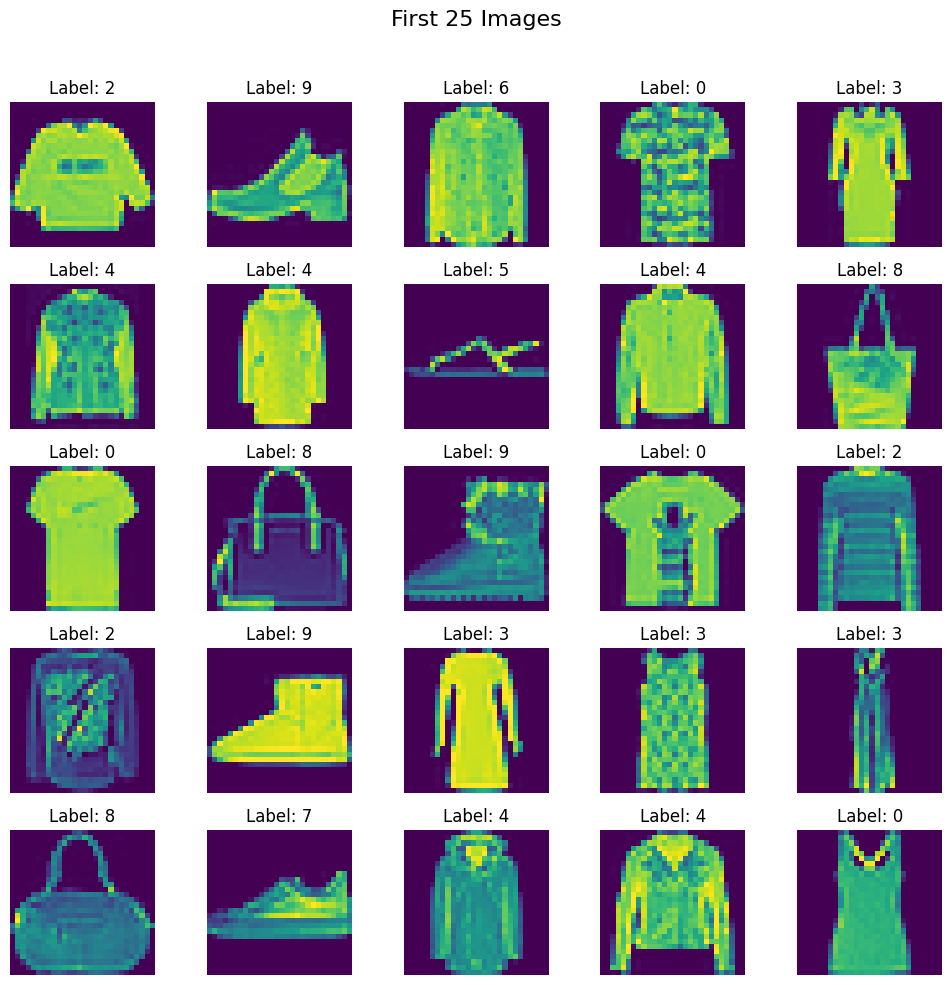

In [7]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle("First 25 Images", fontsize=16)

# Plot the first 25 images from the dataset
# axes.flat converts the 2D grid into a 1D iterator
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)                  # Reshape to 28x28
    ax.imshow(img)                                       # Display in grayscale
    ax.axis('off')                                     # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")               # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])          # Adjust layout to fit the title
plt.show()

In [8]:
df['label'].value_counts()

,count
label,
2,6000
9,6000
6,6000
0,6000
3,6000
4,6000
5,6000
8,6000
7,6000


In [9]:
x = df.iloc[:, 1:].values
y = df['label'].values

In [10]:
x.shape

(60000, 784)

In [11]:
y

array([2, 9, 6, ..., 8, 8, 7])

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 2)

In [13]:
print("shape of x_train", x_train.shape)
print("shape of x_test", x_test.shape)
print("shape of y_train", y_train.shape)
print("shape of y_test", y_test.shape)

shape of x_train (48000, 784)
shape of x_test (12000, 784)
shape of y_train (48000,)
shape of y_test (12000,)


In [14]:
# scaling the features
x_train = x_train/255.0
x_test = x_test/255.0

In [15]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
# create custom dataset

class customdataset(Dataset):

  def __init__(self, features, labels):
    self.features = torch.tensor(features, dtype = torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    return self.features[idx], self.labels[idx]

In [17]:
# create dataset object
x_train_dataset = customdataset(x_train, y_train)
x_test_dataset = customdataset(x_test, y_test)

In [18]:
len(x_train_dataset)

48000

In [41]:
class MyNN(nn.Module):

  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):

    super().__init__()

    layers = []

    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):

    return self.model(x)


In [45]:
# objective function
def objective(trial):


  # next hyperparameter values from scratch space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step = 8)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step = 0.1)
  learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1, log = True)
  epochs = trial.suggest_int("epochs", 10, 50, step = 10)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log = True)


  # create dataloader
  x_train_loader = DataLoader(x_train_dataset, batch_size = batch_size, shuffle = True, pin_memory = True)
  x_test_loader = DataLoader(x_test_dataset, batch_size = batch_size, shuffle = False, pin_memory = True)


  # model initialize
  inp_dim = 784
  out_dim = 10

  model = MyNN(inp_dim, out_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)


  # optimizer selection
  loss = nn.CrossEntropyLoss()
  opt = optim.SGD(model.parameters(), lr = learning_rate)

  if optimizer_name == 'Adam':
    opt = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
  elif optimizer_name == 'SGD':
    opt = optim.SGD(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
  else:
    opt = optim.RMSprop(model.parameters(), lr = learning_rate, weight_decay = weight_decay)


  # training loop
  for i in range(epochs):

    for batch_feat, batch_labels in x_train_loader:

      # move to gpu
      batch_feat = batch_feat.to(device)
      batch_labels = batch_labels.to(device)

      # forward pass
      out = model(batch_feat)

      # loss calculation
      l =   loss(out, batch_labels)

      # backward pass
      opt.zero_grad()
      l.backward()

      # parameters update
      opt.step()


  # evaluation
  model.eval()

  total = 0
  correct = 0

  with torch.no_grad():
    for batch_feat, batch_labels in x_test_loader:

      batch_feat = batch_feat.to(device)
      batch_labels = batch_labels.to(device)

      out = model(batch_feat)

      _, pred = torch.max(out, 1)

      total += batch_labels.shape[0]
      correct += (pred == batch_labels).sum().item()

      acc = correct/total
      return acc

In [46]:
import optuna

study = optuna.create_study(direction='maximize')

[I 2026-01-15 21:45:09,454] A new study created in memory with name: no-name-f9cd8d51-ccd7-4a14-a040-b28779170aef


In [47]:
study.optimize(objective, n_trials=10)

[I 2026-01-15 21:48:46,580] Trial 0 finished with value: 0.75 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 96, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.018327212002866057, 'epochs': 40, 'batch_size': 16, 'optimizer': 'RMSprop', 'weight_decay': 3.0005474296608758e-05}. Best is trial 0 with value: 0.75.
[I 2026-01-15 21:51:01,954] Trial 1 finished with value: 0.6875 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 72, 'dropout_rate': 0.4, 'learning_rate': 0.01643951422940782, 'epochs': 40, 'batch_size': 32, 'optimizer': 'RMSprop', 'weight_decay': 2.5342009236402823e-05}. Best is trial 0 with value: 0.75.
[I 2026-01-15 21:53:46,058] Trial 2 finished with value: 0.75 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 48, 'dropout_rate': 0.2, 'learning_rate': 0.008700437660225864, 'epochs': 30, 'batch_size': 32, 'optimizer': 'Adam', 'weight_decay': 0.00034453072353829927}. Best is trial 0 with value: 0.75.
[I 2026-01-15 21:54:44,443] T

In [48]:
study.best_params

{'num_hidden_layers': 5,
 'neurons_per_layer': 56,
 'dropout_rate': 0.1,
 'learning_rate': 0.00905080159268716,
 'epochs': 10,
 'batch_size': 16,
 'optimizer': 'SGD',
 'weight_decay': 0.0003142378537843591}

In [49]:
study.best_value

0.9375